# Hourglass Network
## For keypoints extraction

In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
from hourglass import HourglassNetwork

TRAIN = True

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"


### Path to data

In [2]:
MODEL_PATH = "./data/model"

IMAGES_PATH = "../YCB-Video_data/data/0010"
IMAGES = [f"{IMAGES_PATH}/{f}" for f in os.listdir(IMAGES_PATH) if f.endswith("color.png")]
DIM = (480, 640, 3)
N = len(IMAGES)

KEYPOINTS_PATH = "../YCB-Video_data/keypoints/0010_gt_keypoints2d.npy"
KEYPOINTS = np.load(KEYPOINTS_PATH)

### Keypoints to heatmaps finctions

In [3]:
def gaussian_k(x0: int, y0: int, sigma: float, height: int, width: int) -> np.ndarray:
        """ Make a square gaussian kernel centered at (x0, y0) with sigma as SD. """
        x = np.arange(0, width, 1, float) ## (width,)
        y = np.arange(0, height, 1, float)[:, np.newaxis] ## (height,1)
        return np.exp(-((x-x0)**2 + (y-y0)**2) / (2*sigma**2))

def generate_heatmap(height: int, width: int, landmarks: List[Tuple[int, int]], s: int = 3) -> np.ndarray:
        """ Generate a full Heap Map for every landmarks in an array
        Args:
            height    : The height of Heat Map (the height of target output)
            width     : The width  of Heat Map (the width of target output)
            joints    : [(x1,y1),(x2,y2)...] containing landmarks
            maxlenght : Lenght of the Bounding Box
        """
        Nlandmarks = len(landmarks)
        hm = np.zeros((height, width, Nlandmarks), dtype = np.float32)
        for i in range(Nlandmarks):
            if not np.array_equal(landmarks[i], [-1,-1]):
             
                hm[:,:,i] = gaussian_k(landmarks[i][0],
                                        landmarks[i][1],
                                        s,height, width)
            else:
                hm[:,:,i] = np.zeros((height,width))
        return hm

### Batch generator

In [4]:
def batchgen(images: List[str], keypoints: np.ndarray, dataset_size: int, batch_size: int, epochs: int) -> Tuple[np.ndarray, np.ndarray]:
    for _ in range(epochs):
        for i in range(0, dataset_size, batch_size):
            x_batch = np.array([cv2.imread(img, cv2.IMREAD_GRAYSCALE) for img in images[i:i+batch_size]])
            y_batch = np.array([generate_heatmap(DIM[0]//4, DIM[1]//4, k//4) for k in keypoints[i:i+batch_size]])
            out_size = y_batch.shape[1] * y_batch.shape[2] * y_batch.shape[3]
            yield np.reshape(x_batch, (*x_batch.shape, 1)), np.reshape(y_batch, (y_batch.shape[0], out_size, 1))


### Create Hourglass neural network

In [5]:
num_classes = 9
num_stacks = 1
num_filters = 128

net = HourglassNetwork(num_classes, num_stacks,
                       num_filters, DIM[:-1], DIM[:-1])
net.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 480, 640, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 240, 320, 32  1600        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 240, 320, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

### Train

In [6]:
if TRAIN:
    batch_size = 4
    epochs = 50
    hist = net.fit(data_generator=batchgen(IMAGES, KEYPOINTS, dataset_size=N, batch_size=batch_size, epochs=epochs),
                   dataset_size=N,
                   batch_size=batch_size,
                   epochs=epochs)
    net.model.save(MODEL_PATH)
else:
    net.load(MODEL_PATH)


Epoch 1/50
79/79 [==============================] - 202s 2s/step - loss: 31.6877 - accuracy: 0.7536
Epoch 2/50
79/79 [==============================] - 181s 2s/step - loss: 0.0045 - accuracy: 0.7618
Epoch 3/50
79/79 [==============================] - 157s 2s/step - loss: 0.0016 - accuracy: 0.7619
Epoch 4/50
79/79 [==============================] - 145s 2s/step - loss: 0.0013 - accuracy: 0.7618
Epoch 5/50
79/79 [==============================] - 141s 2s/step - loss: 9.0274e-04 - accuracy: 0.7618
Epoch 6/50
79/79 [==============================] - 142s 2s/step - loss: 5.9813e-04 - accuracy: 0.7619
Epoch 7/50
79/79 [==============================] - 144s 2s/step - loss: 4.6117e-04 - accuracy: 0.7620
Epoch 8/50
79/79 [==============================] - 144s 2s/step - loss: 4.1779e-04 - accuracy: 0.7620
Epoch 9/50
79/79 [==============================] - 145s 2s/step - loss: 3.4388e-04 - accuracy: 0.7620
Epoch 10/50
79/79 [==============================] - 145s 2s/step - loss: 2.9985e-04 - a

In [ ]:
plt.plot(hist.history['loss'])
plt.title("Training loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

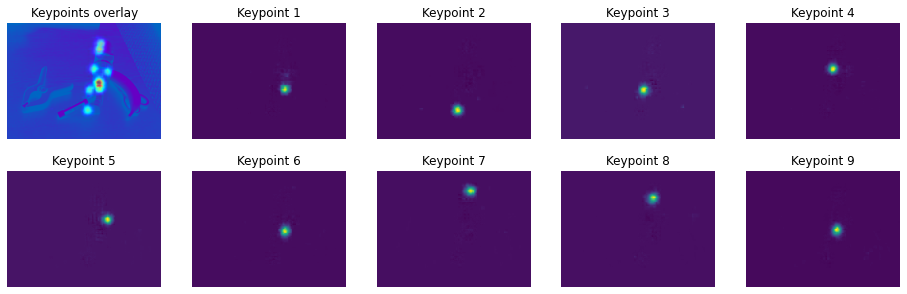

In [27]:
def overlay_heatmap(img: np.ndarray, heatmap: np.ndarray) -> np.ndarray:
    _heatmap = heatmap.sum(axis=-1) # sum all heatmaps
    _heatmap = cv2.normalize(_heatmap, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    _heatmap = cv2.resize(_heatmap, (640, 480))  # resize
    _heatmap = cv2.applyColorMap(_heatmap, cv2.COLORMAP_JET)
    _img = cv2.applyColorMap(img, cv2.COLOR_GRAY2RGB)
    return cv2.addWeighted(_heatmap, .6, _img, .4, 0)


gen = batchgen(IMAGES, KEYPOINTS, dataset_size=N, batch_size=1, epochs=1)
x, y = next(gen)
out = net.predict(x)
out.shape = (-1, DIM[0]//4, DIM[1]//4, 9)

overlay = overlay_heatmap(x[0, :, :, 0], out[0])
overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(16, 5))
plt.subplot(251)
plt.axis("off")
plt.imshow(overlay)
plt.title("Keypoints overlay")
for i in range(out.shape[-1]):
    plt.subplot(2, 5, i+2)
    plt.axis("off")
    plt.imshow(out[0, :, :, i])
    plt.title(f"Keypoint {i+1}")
plt.show()